In [1]:
import sys
import os
rise_sfl_path = "/content/RISE-SFL/causal-explainer"  # Replace with the actual path to your RISE-SFL folder
sys.path.append(rise_sfl_path)
from utils.utils import *
# From masker/generation.py
from masker.generation import SFL

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from PIL import Image
import json
from torch.nn.functional import softmax, conv2d
import os
import requests
import zipfile

In [2]:
cudnn.benchmark = True
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False


c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from masker.batch import SFL_batch

input_size = (224,224)
sfl_batch = SFL_batch(model, input_size)
image_folder = r'C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\RISE-SFL\data_demo'
N = 100
s = 8
p1 = 0.2
masks, sampled_tensors, target_list = sfl_batch.generate_batch_images(image_folder, N, s, p1)

Processing images:   0%|          | 0/24 [00:00<?, ?it/s]c:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\RISE-SFL\RISE-SFL\masker\generation.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cell_size = torch.ceil(torch.tensor(self.input_size).float() / s)
Processing images: 100%|██████████| 24/24 [26:40<00:00, 66.71s/it]  


In [4]:
def generate_pass_fail_list(N):
    return ["Pass" if i % 2 == 0 else "Fail" for i in range(N)]

pass_fail_list = generate_pass_fail_list(N)

savepath = 'mask.npy'
mask_array = masks.detach().cpu().numpy()
np.save(savepath, mask_array)

print(masks.shape)
from visuals.plots import SFLVisualizer

torch.Size([24, 100, 1, 224, 224])


In [5]:
#If we want to observe any of the images that are being explained, we just need to 
visualizer = SFLVisualizer()
visualizer.interactive_mutant_visualization(sampled_tensors[20], pass_fail_list)


interactive(children=(IntSlider(value=0, description='Mutant Index:', max=99), Output()), _dom_classes=('widge…

In [11]:
#from sfl_techniques.sfl import RelevanceScore
#A dictionary will be return for the image to be explained
with torch.no_grad():
    output = model(sampled_tensors[0])
    top_probabilities, top_classes = torch.topk(output, k=3, dim=1)
    top_pred_class = top_classes[0][0].item()

for zx in range(3):
    class_name = top_classes[0][zx].item()
    percentage = top_probabilities[0][zx].item() * 100
    print(f'Top {zx+1} class: {class_name}, Probability: {percentage:.2f}%')

confidence_scores = []
for ss in range(100):
    score = top_probabilities[ss][0].item() * 100
    confidence_scores.append(score)

Top 1 class: 243, Probability: 37.35%
Top 2 class: 242, Probability: 35.33%
Top 3 class: 180, Probability: 8.38%


In [ ]:
# Initialize list to store confidence scores for each original image
confidence_scores = np.zeros((24, 100))

# Process the batch of images
with torch.no_grad():
    for i in range(24):  # For each original image
        for j in range(100):  # For each mutation
            # Extract single image tensor
            single_image = sampled_tensors[i, j].unsqueeze(0)  # Add batch dimension
            
            # Process single image
            output = model(single_image)
            
            # Get top prediction
            top_probability = torch.max(output, dim=1)
            
            # Store confidence score for this mutation
            confidence_scores[i, j] = top_probability.values.item() * 100
            
            # Print top 3 predictions for the first mutation of each original image
            if j == 0:
                top_probabilities, top_classes = torch.topk(output, k=3, dim=1)
                print(f"\nResults for Original Image {i+1}, First Mutation:")
                for k in range(3):
                    class_name = top_classes[0][k].item()
                    percentage = top_probabilities[0][k].item() * 100
                    print(f'Top {k+1} class: {class_name}, Probability: {percentage:.2f}%')

In [34]:
print(confidence_scores[0][2])
%reload_ext autoreload
%autoreload 2

17.195315659046173


In [36]:
# For each image, after returning the dictionary, we need to use causal metrics to calculate which one is more efficient
from sfl_techniques.relevance_score import RelevanceScore
relevance_score_calculator = RelevanceScore(device='cuda')

pixel_datasets = []
ochiai_array = []
zoltar_array = []
tarantula_array = []
wong1_array = []
for i in range(24):
    pixel_dataset, ochiai, tarantula, zoltar, wong1 = relevance_score_calculator.run(confidence_scores[i], sampled_tensors[i], masks[i], N)
    pixel_datasets.append(pixel_dataset)
    ochiai_array.append(ochiai)
    zoltar_array.append(zoltar)
    tarantula_array.append(tarantula)
    wong1_array.append(wong1)

KeyboardInterrupt: 

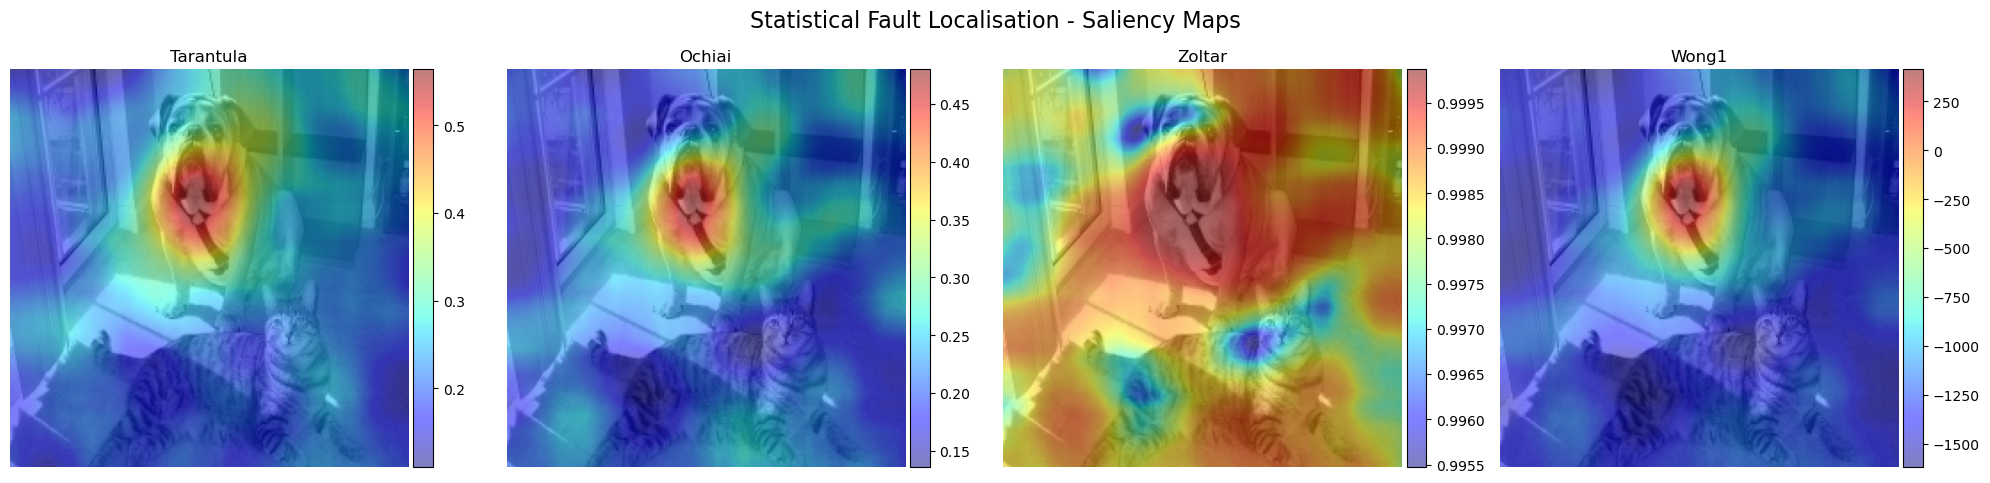

In [15]:
from visuals.saliency_maps.saliency import SaliencyMapVisualizer

# List all files in the directory
all_files = os.listdir(image_folder)

# Filter for .jpg and .png files
image_files = [file for file in all_files if file.lower().endswith(('.jpg', '.png'))]


saliency_map = SaliencyMapVisualizer(r'C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\RISE-SFL\data_demo\catdog.png')
saliency_map.visualize_pixel_scores(pixel_datasets[0],ins='')


In [16]:
rise_sfl_path = r"C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\metrics-saliency-maps"  # Replace with the actual path to your RISE-SFL folder
sys.path.append(rise_sfl_path)


from saliency_maps_metrics.multi_step_metrics import Deletion, Insertion, compute_correlation, compute_auc_metric
from saliency_maps_metrics.data_replace import select_data_replace_method

deletion_metric = Deletion(data_replace_method="black", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)
insertion_metric = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)

# Set up the path to your RISE-SFL folder
rise_sfl_path = r"C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\RISEX"
sys.path.append(rise_sfl_path)


In [17]:
from tabulate import tabulate
import torch
import numpy as np
import os
from tqdm import tqdm

device = 'cuda'
model.to(device)


def get_all_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

# Use the function to get all image files
image_files = get_all_image_files(image_folder)

# Check if there are any image files in the directory
if not image_files:
    print("No image files found in the specified directory or its subdirectories.")
else:
    print(f"Found {len(image_files)} image files.")

    device = 'cuda'
    model.to(device)

# Function to calculate sparsity
def calculate_sparsity(saliency_map):
    max_value = np.max(saliency_map)
    mean_value = np.mean(saliency_map)
    return max_value / mean_value if mean_value != 0 else float('inf')

# Create instances of Deletion and Insertion metrics
deletion_metric = Deletion(data_replace_method="black", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)
insertion_metric = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)

# Initialize dictionary to store cumulative results
cumulative_results = {
    "Wong1": {"DAUC": 0, "DC": 0, "IAUC": 0, "IC": 0, "Sparsity": 0},
    "Tarantula": {"DAUC": 0, "DC": 0, "IAUC": 0, "IC": 0, "Sparsity": 0},
    "Zoltar": {"DAUC": 0, "DC": 0, "IAUC": 0, "IC": 0, "Sparsity": 0},
    "Ochiai": {"DAUC": 0, "DC": 0, "IAUC": 0, "IC": 0, "Sparsity": 0}
}

# Get list of image files
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for i, (image_file, target_class) in enumerate(zip(image_files, target_list)):
    image_path = os.path.join(image_folder, image_file)
    img = read_tensor(image_path).to(device)

    # Create a dictionary of saliency maps for this image
    saliency_maps = {
        "Wong1": wong1_array[i][0],
        "Tarantula": tarantula_array[i][0],
        "Zoltar": zoltar_array[i][0],
        "Ochiai": ochiai_array[i][0]
    }

    # Process each saliency map for this image
    for name, saliency_map in saliency_maps.items():
        saliency_map_tensor = torch.from_numpy(saliency_map).float().unsqueeze(0).unsqueeze(0).to(device)

        # Compute Deletion metrics
        deletion_result = deletion_metric(model, img, saliency_map_tensor, class_to_explain_list=[target_class])
        cumulative_results[name]["DAUC"] += deletion_result["dauc"]
        cumulative_results[name]["DC"] += deletion_result["dc"]

        # Compute Insertion metrics
        insertion_result = insertion_metric(model, img, saliency_map_tensor, class_to_explain_list=[target_class])
        cumulative_results[name]["IAUC"] += insertion_result["iauc"]
        cumulative_results[name]["IC"] += insertion_result["ic"]

        # Calculate sparsity
        cumulative_results[name]["Sparsity"] += calculate_sparsity(saliency_map)

# Calculate averages
num_images = len(image_files)
results = []
for name, metrics in cumulative_results.items():
    avg_metrics = [name] + [metrics[key] / num_images for key in ["DAUC", "DC", "IAUC", "IC", "Sparsity"]]
    results.append(avg_metrics)

# Create a table using tabulate
headers = ["Saliency Map", "Avg DAUC", "Avg DC", "Avg IAUC", "Avg IC", "Avg Sparsity"]
table = tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f")

# Print the table
print(f"Average Metrics for {num_images} images:")
print(table)

Found 24 image files.
Average Metrics for 24 images:
+----------------+------------+----------+------------+----------+----------------+
| Saliency Map   |   Avg DAUC |   Avg DC |   Avg IAUC |   Avg IC |   Avg Sparsity |
+================+============+==========+============+==========+================+
| Wong1          |     0.0783 |   0.3466 |     0.6721 |   0.0998 |         3.9891 |
+----------------+------------+----------+------------+----------+----------------+
| Tarantula      |     0.0916 |   0.3195 |     0.6424 |   0.1023 |         3.8889 |
+----------------+------------+----------+------------+----------+----------------+
| Zoltar         |     0.0741 |   0.1667 |     0.6745 |   0.0982 |         1.3108 |
+----------------+------------+----------+------------+----------+----------------+
| Ochiai         |     0.0723 |   0.3358 |     0.6732 |   0.0978 |         4.3482 |
+----------------+------------+----------+------------+----------+----------------+
